Epoch [100/1000], Loss: 0.0921
Epoch [200/1000], Loss: 0.0889
Epoch [300/1000], Loss: 0.0878
Epoch [400/1000], Loss: 0.0871
Epoch [500/1000], Loss: 0.0867
Epoch [600/1000], Loss: 0.0862
Epoch [700/1000], Loss: 0.0857
Epoch [800/1000], Loss: 0.0850
Epoch [900/1000], Loss: 0.0845
Epoch [1000/1000], Loss: 0.0842
Predicted parameters:
[0.6203370690345764, 752.575927734375, 0.0515897236764431, 0.5683169960975647, 775.421875, 478.02349853515625, 462.76519775390625]


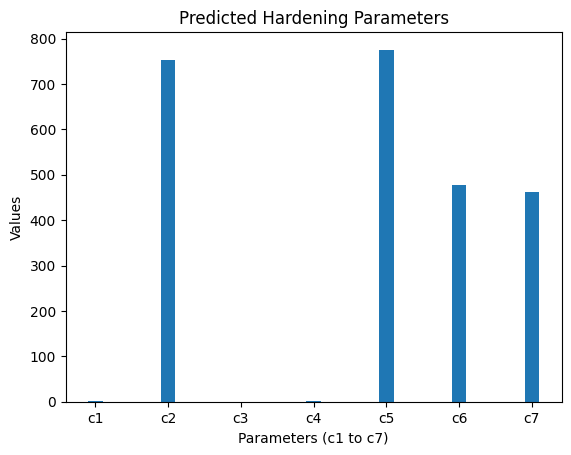

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from skorch.helper import SliceDict

# Load data from a single combined CSV file
combined_FD_file = "MODEL_DATA/NEWDATA/newData_combined_FD.csv"

combined_FD_data = pd.read_csv(combined_FD_file)

# Split the combined data into X (input) and Y (output) data
X_data = combined_FD_data.iloc[:, :8].values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Define a custom neural network model with L2 regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, lambda_reg):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu_out = nn.ReLU()

        # Create a list of all the layers you want to apply L2 regularization to
        self.regularization_layers = [self.fc1, self.fc2, self.fc3]

        # Define the regularization strength (lambda)
        self.lambda_reg = lambda_reg

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

    def l2_regularization(self):
        # Calculate L2 regularization loss
        l2_reg = 0.0
        for layer in self.regularization_layers:
            l2_reg += torch.norm(layer.weight)
        return self.lambda_reg * l2_reg

# Custom loss function with regularization
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomMSELoss, self).__init()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, target_values):
        mse_loss = nn.MSELoss()(outputs, targets)
        return mse_loss + self.lambda_reg * target_values

input_size = 8  # Number of input parameters (Force and Displacement for each geometry)
hidden_size1 = 64
hidden_size2 = 64
output_size = 7  # Number of output dimensions (c1 to c7)

# Define the L2 regularization strength (lambda)
lambda_reg = 0.001

# Create Min-Max scalers for input data and target values
input_scaler = MinMaxScaler()
X_data_scaled = input_scaler.fit_transform(X_data)

target_scaler = MinMaxScaler()
Y_data_scaled = target_scaler.fit_transform(Y_data)

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size, lambda_reg)

# Define a loss function (custom MSE loss with L2 regularization) and an optimizer (e.g., Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(torch.tensor(X_data_scaled, dtype=torch.float32))

    # Inverse scale the predictions to the original range
    predictions = target_scaler.inverse_transform(outputs.detach().numpy())

    # Compute the MSE loss
    mse_loss = criterion(outputs, torch.tensor(Y_data_scaled, dtype=torch.float32))

    # Calculate L2 regularization separately
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param, p=2)

    # Combine the MSE loss and L2 regularization
    loss = mse_loss + lambda_reg * l2_reg

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

# Load the trained model for prediction
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()

# Predict parameters
X_test_scaled = input_scaler.transform(X_data[:1])
with torch.no_grad():
    predictions = model(torch.tensor(X_test_scaled, dtype=torch.float32))

# Inverse scale the predictions to the original range
predictions = target_scaler.inverse_transform(predictions.detach().numpy())

# Print predicted parameters
print(f'Predicted parameters:')
print(predictions[0].tolist())

# Visualize 'c1' to 'c7' values in a single graph
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = predictions[0].tolist()

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Predicted Hardening Parameters')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()